In [8]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob

sns.set(context='talk', style='white')

study_dir = '/Users/catcamacho/Library/CloudStorage/Box-Box/CRAB/CRAB_lab/studies/crab-seal_hbcdmovies_pilot_2025'
data_dir = os.path.join(study_dir, 'DATA','V1_motrak')
out_dir = os.path.join(study_dir, 'DATA','V1_motion_processed')
timing = pd.read_csv(os.path.join(study_dir, 'measures','clips','ClipsTimingForAnalysis.csv'), index_col=0)

subIDs = ['2002','2003','2004','2005','2006','2010','2011','2012']

               set  version clips_version  start_sec  duration_sec
clip_name                                                         
birds            2        3          orig          0           180
bluey            2        3          orig        213           382
lou              2        3          orig        607           360
boundin          2        3          orig        976           267
despicable_me    2        3          orig       1361           600


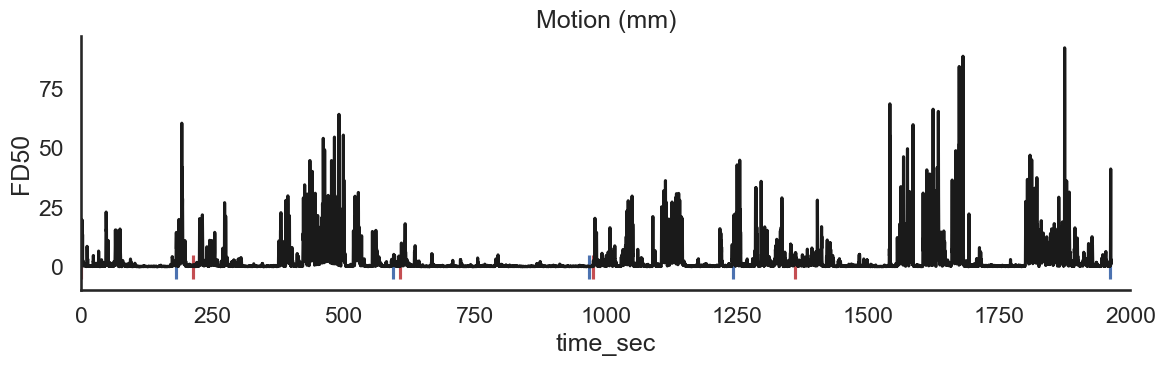

               set  version clips_version  start_sec  duration_sec
clip_name                                                         
birds            2        3          orig          0           180
bluey            2        3          orig        213           382
lou              2        3          orig        607           360
boundin          2        3          orig        976           267
despicable_me    2        3          orig       1361           600


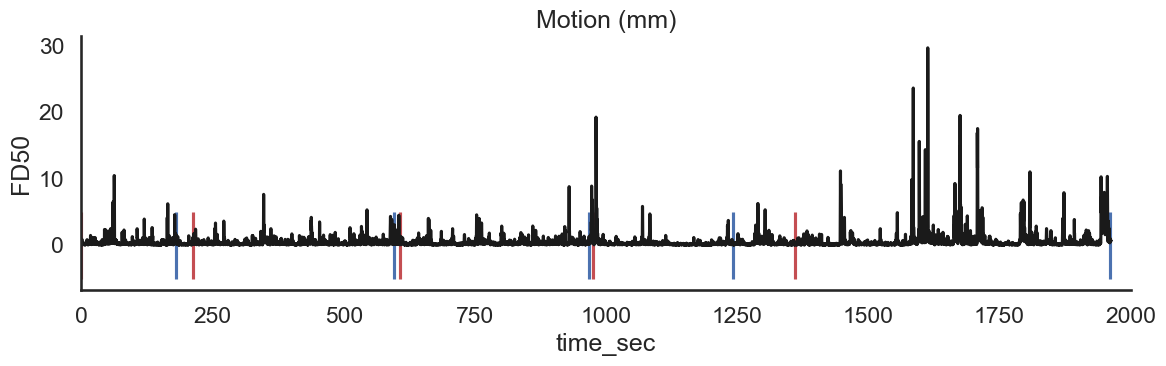

                 set  version clips_version  start_sec  duration_sec
clip_name                                                           
partysaurus_rex    1        3          orig          0           394
one_man_band       1        3          orig        404           273
aeronaut           1        3          orig        687           180
piper              1        3          orig        877           364
small_fry          1        3          orig       1251           425
frozen             1        3          orig       1686           306


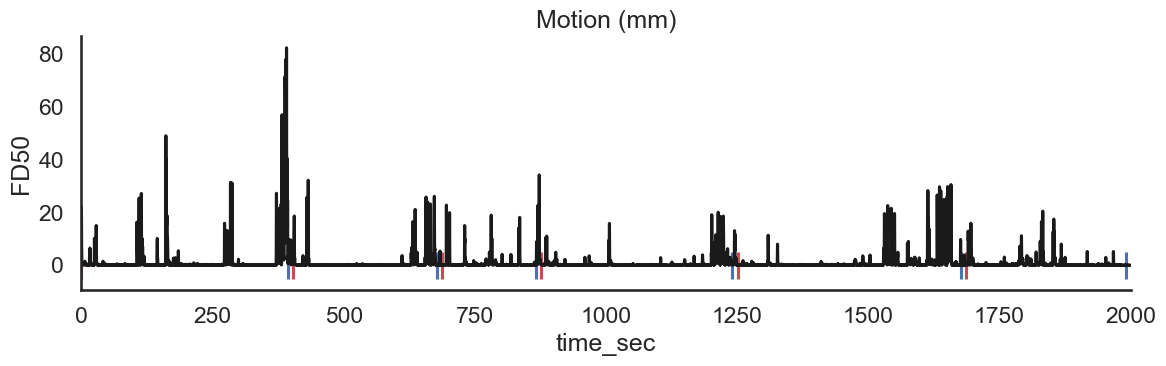

                 set  version clips_version  start_sec  duration_sec
clip_name                                                           
small_fry          1        2          orig          0           425
piper              1        2          orig        435           365
partysaurus_rex    1        2          orig        810           394
one_man_band       1        2          orig       1214           273
frozen             1        2          orig       1496           306
aeronaut           1        2          orig       1812           180


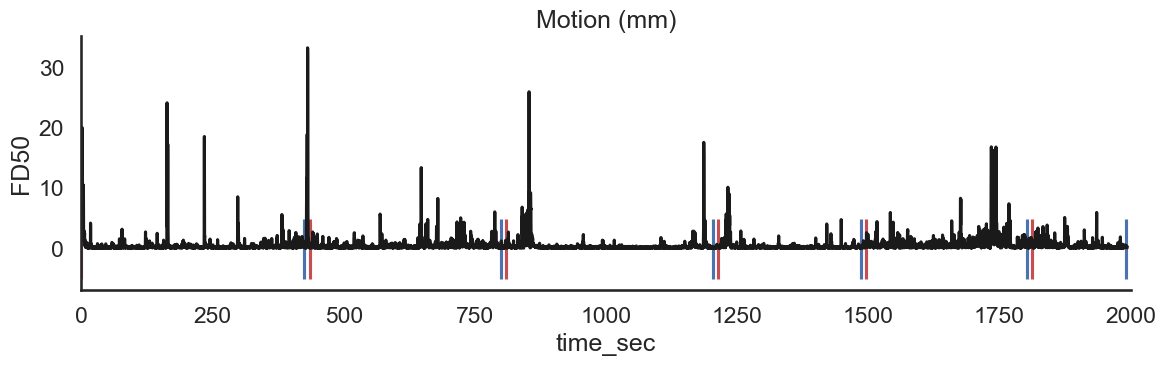

                 set  version clips_version  start_sec  duration_sec
clip_name                                                           
aeronaut           1        1           new          0           180
frozen             1        1           new        190           305
one_man_band       1        1           new        506           256
partysaurus_rex    1        1           new        772           371
piper              1        1           new       1155           333
small_fry          1        1           new       1499           391


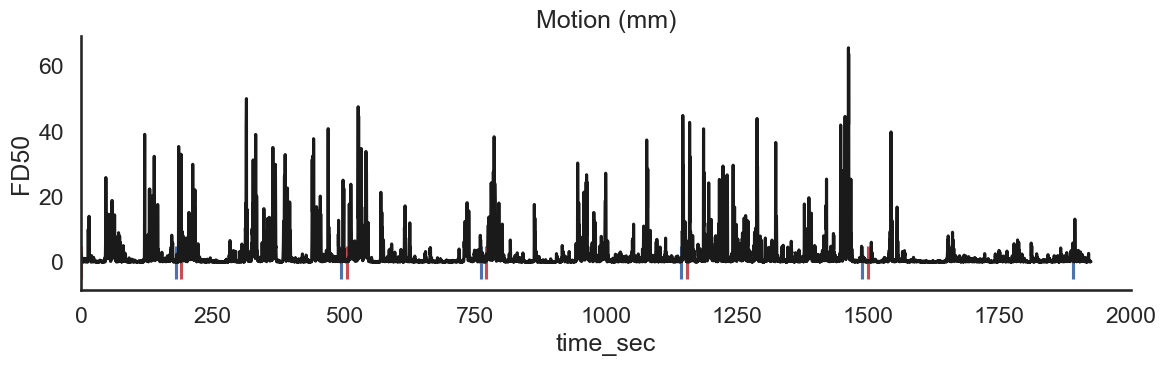

                    set  version clips_version  start_sec  duration_sec
clip_name                                                              
la_luna               4        3           new          0           382
sanjays_super_team    4        3           new        393           395
jackjack_attack       4        3           new        799           249
bao                   4        3           new       1060           428
moana                 4        3           new       1499           372


/usr/local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


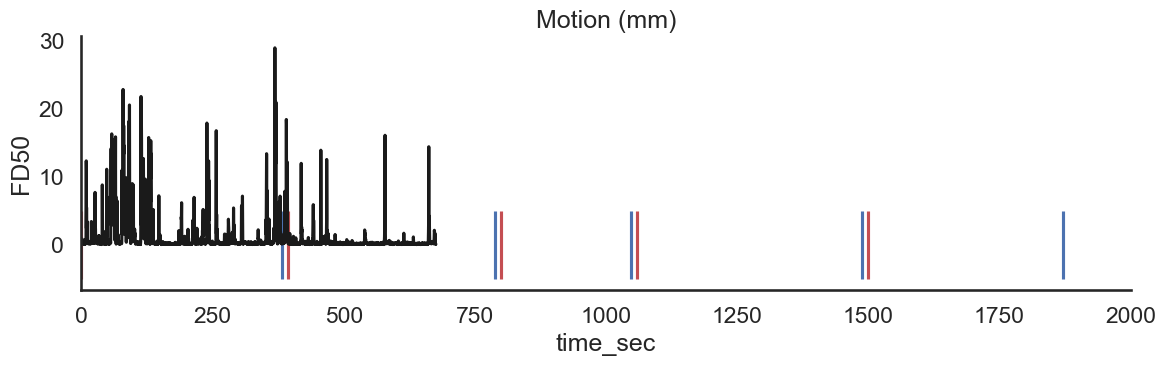

               set  version clips_version  start_sec  duration_sec
clip_name                                                         
air_mater        3        1           new          0           295
inside_out       3        1           new        307           479
mikes_new_car    3        1           new        796           212
partly_cloudy    3        1           new       1020           313
party_central    3        1           new       1344           300
zootopia         3        1           new       1656           299


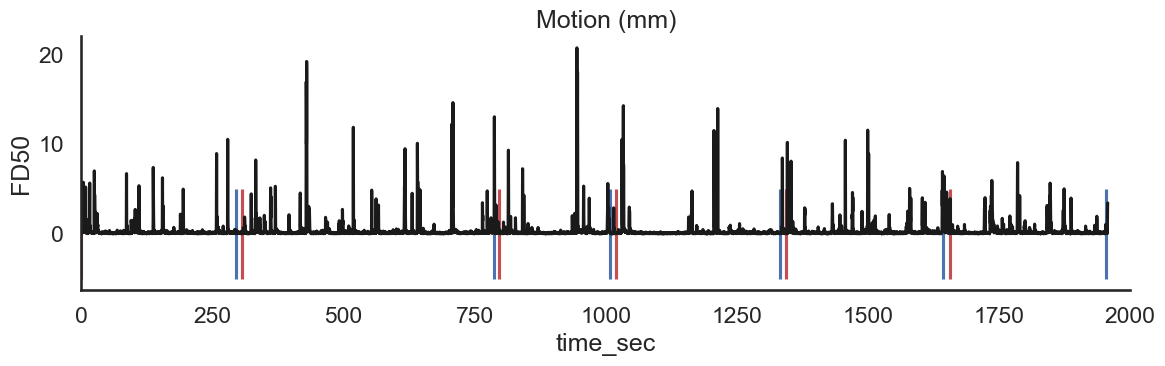

                 set  version clips_version  start_sec  duration_sec
clip_name                                                           
small_fry          1        2           new          0           390
piper              1        2           new        403           333
partysaurus_rex    1        2           new        747           370
one_man_band       1        2           new       1129           255
frozen             1        2           new       1394           305
aeronaut           1        2           new       1710           179


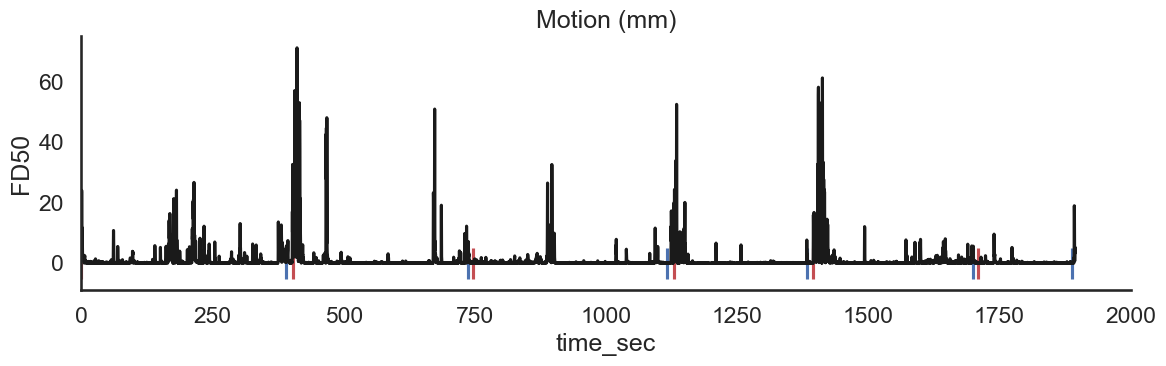

In [10]:
for sub in subIDs:
    os.makedirs(os.path.join(out_dir,sub),exist_ok=True)
    file = glob(os.path.join(data_dir, sub, '*.txt'))[0]
    motion = pd.read_csv(file, index_col=0, delimiter='\t')

    listnum = int(os.path.basename(file).split('_')[1][-1])
    versnum = int(os.path.basename(file).split('_')[2][-1])
    oldnew = os.path.basename(file).split('_')[3][:-4]
    subtime = timing.loc[(timing['set']==listnum) & (timing['version']==versnum) & (timing['clips_version']==oldnew),:]

    # identify frames where movie is not playing
    motion.loc[:,'movie_d'] = pd.to_datetime(motion.loc[:,'Movie Time'])
    motion.loc[:,'movie_d'] = motion['Movie Time'].eq(motion['Movie Time'].shift())
    motion.to_csv(os.path.join(out_dir,sub,'{0}_motion_data_temp.csv'.format(sub)))
    
    # convert index to datetime then seconds
    origind = motion.index
    motion.index = pd.to_datetime(origind)
    zeroed_times = motion.loc[motion['Events']=='Zeroed',:].index.to_numpy()
    motion = motion.resample('200ms').mean()
    time = np.arange(0,len(motion)/5,0.2)
    motion.index = time
    motion.index.name = 'time_sec'

    # compute 1st derive of motion
    for a in motion.columns:
        motion.loc[:, '{0}1'.format(a)] = np.gradient(motion.loc[:,a])

    # compute FD (adult head size)
    ang = np.absolute(motion.loc[:,['Pitch1','Yaw1','Roll1']])
    ang = ang.loc[:,['Pitch1','Yaw1','Roll1']].sum(min_count=1,axis=1)
    transl = np.absolute(motion.loc[:,['X1','Y1','Z1']])
    transl = transl.loc[:,['X1','Y1','Z1']].sum(min_count=1,axis=1)
    motion.loc[:, 'FD50'] = transl + 50*(np.pi/180)*ang
    
    # drop frames where movie is not playing
    motion = motion.iloc[1:,:]
    motion = motion.loc[motion['movie_d']==False,:].copy()
    motion.index = np.arange(0,len(motion)/5,0.2)
    motion.index.name = 'time_sec'
    
    # summarize motion for each clip separately
    motion_summary = pd.DataFrame()
    for v in subtime.index:
        motion.loc[subtime.loc[v, 'start_sec']:subtime.loc[v, 'start_sec']+subtime.loc[v, 'duration_sec'],'title'] = v
        tempmotion = motion.loc[subtime.loc[v, 'start_sec']:subtime.loc[v, 'start_sec']+subtime.loc[v, 'duration_sec'],:]
        motion_summary.loc[v, 'meanFD'] = tempmotion['FD50'].mean(axis=0)
        motion_summary.loc[v, 'minFD'] = tempmotion['FD50'].min(axis=0)
        motion_summary.loc[v, 'maxFD'] = tempmotion['FD50'].max(axis=0)
        motion_summary.loc[v, 'sdFD'] = tempmotion['FD50'].std(axis=0)
        motion_summary.loc[v, 'pcent_volscens_0.9'] = np.nanmean(tempmotion['FD50']>0.9)
        motion_summary.loc[v, 'pcent_volscens_0.2'] = np.nanmean(tempmotion['FD50']>0.2)

    motion.to_csv(os.path.join(out_dir,sub,'{0}_motion_data_processed.csv'.format(sub)))
    motion_summary.to_csv(os.path.join(out_dir,sub,'{0}_motion_summary.csv'.format(sub)))
    
    # plot overall motion
    fig, ax = plt.subplots(1,1,figsize=(12,4))

    motion.loc[:,'FD50'].plot(ax=ax, color='k')
    ax.vlines(subtime['start_sec'].to_numpy(), ymin=-5, ymax=5, color='r')
    ax.vlines(subtime['start_sec'].to_numpy()+subtime['duration_sec'].to_numpy(), ymin=-5, ymax=5, color='b')
    sns.despine()
    plt.xlim(0,2000)
    plt.ylabel('FD50')
    plt.title('Motion (mm)')
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, sub, '{0}_full_run_plot.png'.format(sub)), dpi=150)
    plt.show()
    plt.close()